In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from fbprophet import Prophet 
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
import itertools
from fbprophet.diagnostics import performance_metrics
from numpy import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
#Lendo e transformando o arquivo CSV em um objeto pandas DataFrame nomeado de "df"
dff = pd.read_csv('C:/Users/juan_/Documents/GitHub/Datasets/demand.csv')

In [3]:
#Verificando o head e tail do CSV
dff

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [4]:
#Analisando algumas informações a respeito do DataFrame
dff.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


In [5]:
#Verificando a existência de dados não preenchidos no DataFrame
dff.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [6]:
#Verificando a relação de dados faltantes com o total de dados
x = (11239/1048575)*100
print(f'Os dados faltantes equivalem à {round(x,3)}% do total dos dados do DataFrame')

Os dados faltantes equivalem à 1.072% do total dos dados do DataFrame


In [7]:
#Os dados não preenchidos beiram 1% do total dos dados, sendo assim, resolvi dropar os dados. 
#Outro motivo para dropar os dados é que não era possível estimar os dados faltantes.

#Dropando as linhas dos dados faltantes e atualizando o DF.
dff.dropna(inplace=True)
dff.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [8]:
#Não está no notebook, mas alguns números possuíam parenteses, o código abaixo é para retirar esses parenteses (servirá lá na frente)
dff['Order_Demand']=dff['Order_Demand'].str.replace('(','',regex=True)
dff['Order_Demand']=dff['Order_Demand'].str.replace(')','',regex=True)

In [9]:
#O código abaixo separa os valores das datas, e após isso, cada valor é atribuído a uma nova coluna no DataFrame
dff[['Year','Month','Day']] = dff['Date'].str.split("/", expand = True)
dff[['Month']] = dff[['Month']].astype(int)
dff[['Year']] = dff[['Year']].astype(int)
#df[['Day']] = df[['Day']].astype(int)

#A retirada dos parenteses dos números foi necessário na hora de converter a coluna "Order_Demand" de str para int
dff[['Order_Demand']] = dff[['Order_Demand']].astype(int)

In [10]:
#Ordenando o DataFrame pela Data
dff['Test'] = dff['Year'].map(str) +'/'+ dff['Month'].map(str)
dff['Test'] = pd.to_datetime(dff['Test'])
dff.sort_values('Date', inplace=True)
dff.reset_index(inplace=True)
dff.drop('index',axis=1,inplace=True)
dff

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day,Test
0,Product_0965,Whse_A,Category_006,2011/1/8,2,2011,1,8,2011-01-01
1,Product_0412,Whse_S,Category_007,2011/10/20,2,2011,10,20,2011-10-01
2,Product_0125,Whse_S,Category_011,2011/10/20,2,2011,10,20,2011-10-01
3,Product_0642,Whse_C,Category_019,2011/10/31,3,2011,10,31,2011-10-01
4,Product_2137,Whse_S,Category_009,2011/11/18,25,2011,11,18,2011-11-01
...,...,...,...,...,...,...,...,...,...
1037331,Product_0689,Whse_J,Category_011,2017/1/6,200,2017,1,6,2017-01-01
1037332,Product_1970,Whse_J,Category_005,2017/1/6,2000,2017,1,6,2017-01-01
1037333,Product_1904,Whse_C,Category_019,2017/1/9,4000,2017,1,9,2017-01-01
1037334,Product_0471,Whse_C,Category_015,2017/1/9,30,2017,1,9,2017-01-01


In [11]:
#Verificando a quantidade de registros de cada armazens
dff[['Warehouse']].value_counts()

Warehouse
Whse_J       764447
Whse_A       142335
Whse_S        88200
Whse_C        42354
dtype: int64

In [12]:
#Analisando os dados do DataFrame original
xdf = dff['Order_Demand'].sum()
print(dff.nunique())
print(f'\nTotal of Order Demands: {xdf}')

Product_Code        2160
Warehouse              4
Product_Category      33
Date                1729
Order_Demand        3309
Year                   7
Month                 12
Day                   31
Test                  68
dtype: int64

Total of Order Demands: 5134173931


In [13]:
df_prod = dff[['Product_Code','Order_Demand','Date','Month','Year','Test']]
df_prod
df_prod[['Product_Code']].value_counts()

Product_Code
Product_1359    16936
Product_1295    10575
Product_1378     9770
Product_0620     9428
Product_1286     8888
                ...  
Product_1698        2
Product_1703        1
Product_0465        1
Product_2099        1
Product_0853        1
Length: 2160, dtype: int64

In [14]:
df = df_prod[(df_prod['Product_Code']=='Product_0620')]
#df['Test'] = df['Year'].map(str) +'/'+ df['Month'].map(str)
df

,Product_Code,Order_Demand,Date,Month,Year,Test
152,Product_0620,10,2011/12/20,12,2011,2011-12-01
176,Product_0620,1,2011/12/20,12,2011,2011-12-01
177,Product_0620,2,2011/12/20,12,2011,2011-12-01
194,Product_0620,3,2011/12/21,12,2011,2011-12-01
216,Product_0620,3,2011/12/21,12,2011,2011-12-01
...,...,...,...,...,...,...
1036872,Product_0620,1,2016/9/9,9,2016,2016-09-01
1036962,Product_0620,2,2016/9/9,9,2016,2016-09-01
1037221,Product_0620,2,2016/9/9,9,2016,2016-09-01
1037249,Product_0620,1,2016/9/9,9,2016,2016-09-01


In [15]:
#df['Date'] = pd.to_datetime(df['Date'])

In [16]:
df = df.groupby(by=['Test']).sum()
df.drop(columns=['Month','Year'],inplace=True)

In [17]:
df.reset_index(inplace=True)

In [18]:
#df['Date'] = pd.to_datetime(df['Test'])
#df

In [19]:
df['ds'] = df['Test']
df['y'] = df['Order_Demand']
df.drop(columns=['Test','Order_Demand'],inplace=True)

In [20]:
size = len(df) - 2 
size

59

In [21]:
train=df[:size]
test=df
train

,ds,y
0,2011-12-01,129
1,2012-01-01,822
2,2012-02-01,960
3,2012-03-01,923
4,2012-04-01,1276
5,2012-05-01,641
6,2012-06-01,955
7,2012-07-01,755
8,2012-08-01,871
9,2012-09-01,534


In [22]:
m=Prophet(
interval_width = 0.95,
yearly_seasonality = True,
weekly_seasonality = True,
daily_seasonality = False,
holidays = None,
changepoint_prior_scale = 0.1,
seasonality_prior_scale= 10.01,
changepoint_range = 0.8,
seasonality_mode = 'multiplicative'
)
m.fit(train)

In [23]:
future = m.make_future_dataframe(periods=2 , freq='M') 

In [24]:
forecast = m.predict(future) 

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
56,2016-08-01,951.876070,558.599438,1333.715761,879.940984,879.940984,879.940984
57,2016-09-01,678.934257,318.234165,1063.186694,860.864720,860.864720,860.864720
58,2016-10-01,805.243069,434.464437,1185.909387,842.403820,842.403820,842.403820
59,2016-10-31,922.199154,540.011538,1314.053761,823.942919,822.671555,825.428677
60,2016-11-30,841.113810,463.080066,1233.908145,805.482019,801.755320,809.623879


C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


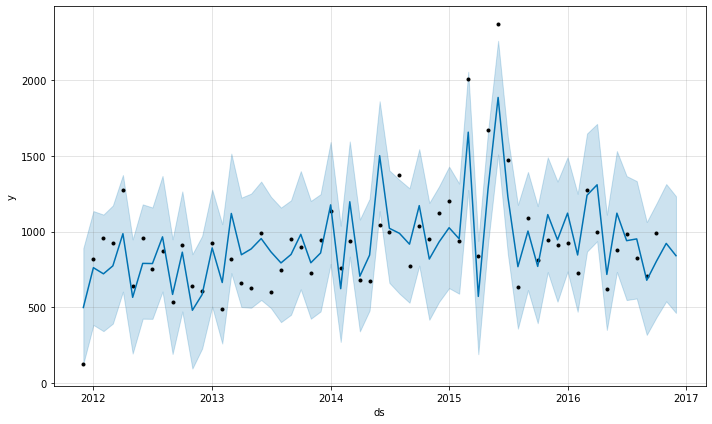

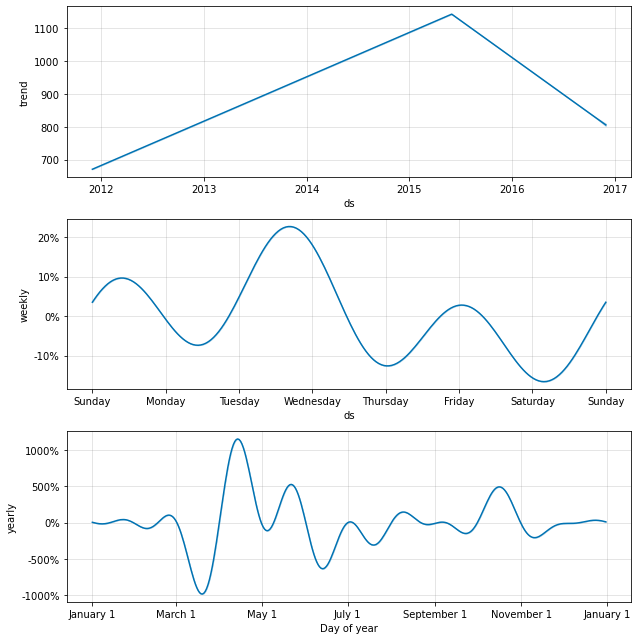

In [25]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

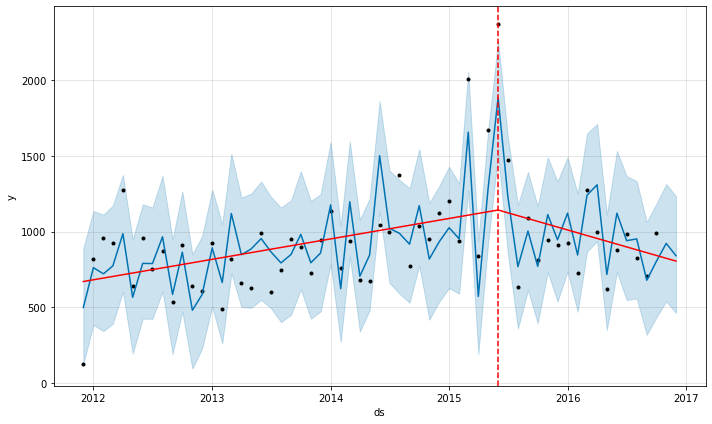

In [26]:
fig = m.plot(forecast) 

a = add_changepoints_to_plot(fig.gca(), m, forecast)

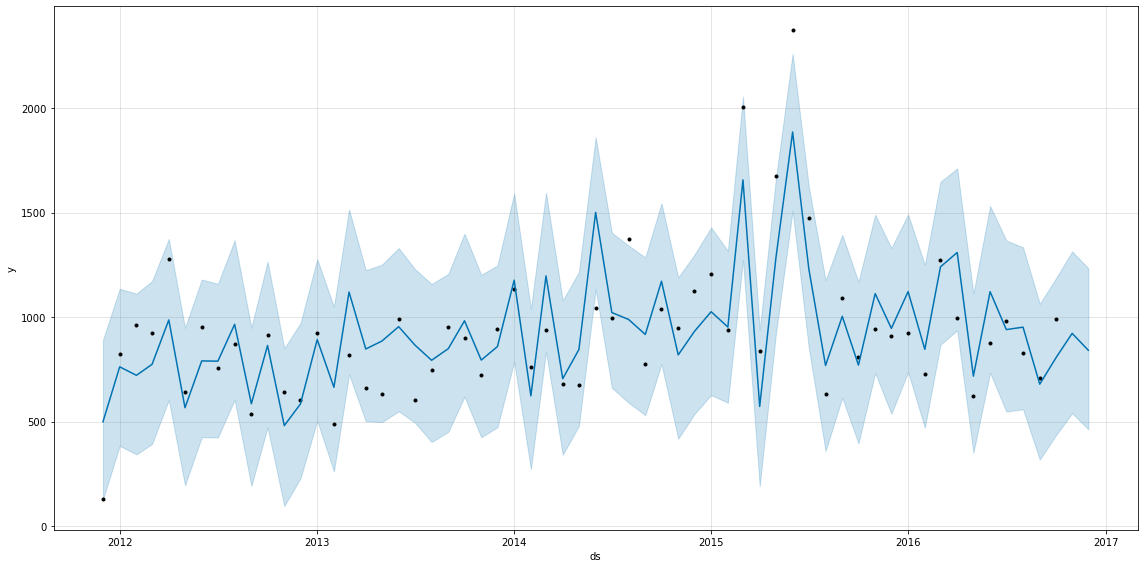

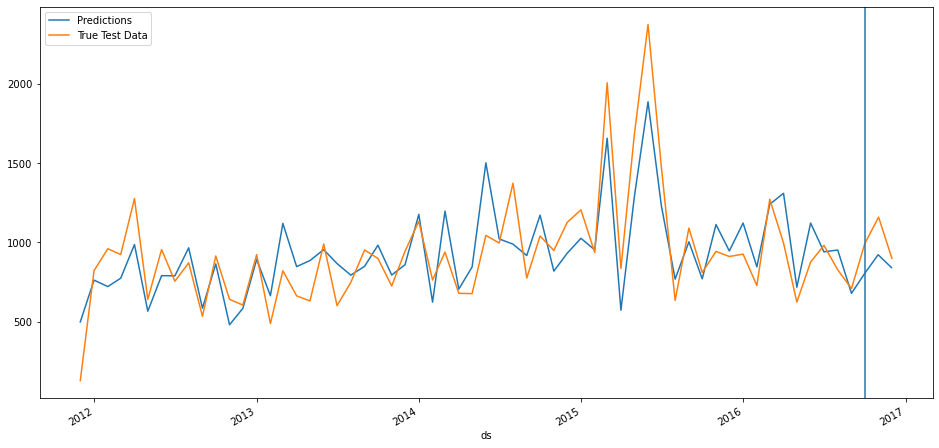

In [27]:
m.plot(forecast,figsize=(16,8))
ax=forecast.plot(x='ds',y='yhat',legend=True,label='Predictions',figsize=(16,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax)
plt.axvline(x='2016-10-01')


In [28]:
df_metrics = pd.DataFrame()
df_metrics['Predicted'] =  forecast['yhat']
df_metrics['True'] = test['y']
df_metrics['Date'] = test['ds']
df_metrics.set_index('Date',inplace=True)
df_metrics

,Predicted,True
Date,,
2011-12-01,499.036082,129
2012-01-01,762.002029,822
2012-02-01,721.386873,960
2012-03-01,774.055669,923
2012-04-01,986.398268,1276
...,...,...
2016-08-01,951.876070,827
2016-09-01,678.934257,709
2016-10-01,805.243069,993


In [29]:
rmse = sqrt(mean_squared_error(test['y'],forecast['yhat']))
rmse

195.5425550160992